In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
import torch
from torch import nn

from models.embedding import SphericalGraphCNN

## Test embedding net

In [4]:
nside_list = [128, 64, 32, 16, 8, 4, 2]

In [5]:
from utils import create_mask as cm

hp_mask_nside1 = cm.make_mask_total(nside=1, band_mask = True, band_mask_range = 0,
                              mask_ring = True, inner = 0, outer = 25)

indexes_list = []
masks_list = []
for nside in nside_list:
    hp_mask = hp.ud_grade(hp_mask_nside1, nside)
    masks_list.append(hp_mask)
    indexes_list.append(np.arange(hp.nside2npix(nside))[~hp_mask])

In [6]:
ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
hp_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 25, custom_mask=ps_mask)
hp_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Test data generation

In [8]:
from models.scd import dnds
from utils.psf_correction import PSFCorrection
from models.psf import KingPSF

In [9]:
kp = KingPSF()

pc_inst = PSFCorrection(delay_compute=True)
pc_inst.psf_r_func = lambda r: kp.psf_fermi_r(r)

In [10]:
from simulations.wrapper import simulator

In [11]:
import sys
from sbi import utils
from sbi import inference

In [12]:
from utils.templates import get_NFW2_template

In [13]:
# Load templates
temp_gce = get_NFW2_template(gamma=1.2)
temp_dif = np.load("../data/fermi_data/template_dif.npy")
temp_psc = np.load("../data/fermi_data/template_psc.npy")
temp_iso = np.load("../data/fermi_data/template_iso.npy")
temp_dsk = np.load("../data/fermi_data/template_dsk.npy")
temp_bub = np.load("../data/fermi_data/template_bub.npy")

temp_mO_pibrem = np.load('../data/fermi_data/ModelO_r25_q1_pibrem.npy')
temp_mO_ics = np.load('../data/fermi_data/ModelO_r25_q1_ics.npy')

temp_mA_pibrem = hp.ud_grade(np.load('../data/modelA/modelA_brempi0.npy'), nside_out=128, power=-2)
temp_mA_ics = hp.ud_grade(np.load('../data/modelA/modelA_ics.npy'), nside_out=128, power=-2)

fermi_exp = np.load("../data/fermi_data/fermidata_exposure.npy")

ps_mask = np.load("../data/mask_3fgl_0p8deg.npy")
roi_mask = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25, custom_mask=ps_mask)
roi_mask_norm = cm.make_mask_total(nside=128, band_mask = True, band_mask_range=2, mask_ring=True, inner=0, outer=25)

In [14]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 8., 4.], [1., 0.22, 0.55, 8.1, 4.1]]

# gce, dsk
prior_ps = [[1.1, 10.0, 1.1, -10.0, 10.0, 0.1, 0.9, 10.0, 1.1, -10.0, 24.0, 0.1], [1.2, 20.0, 1.99, -9.99, 25.0, 4.99, 1.0, 20.0, 1.99, -9.99, 25.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.001] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((10,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func) for theta in tqdm_notebook(thetas)]

from operator import itemgetter
data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

## SNPE

In [15]:
sg_embed = SphericalGraphCNN(nside_list, indexes_list, n_aux=2, n_params=0).to(device)

In [16]:
from sbi.inference import PosteriorEstimator
from sbi import utils
from sbi import inference

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
# iso, bub, psc, dif_pibrem, dif_ics
prior_poiss = [[0.001, 0.001, 0.001, 6., 1.], [1.5, 1.5, 1.5, 12., 6.]]

# gce, dsk
prior_ps = [[0.001, 10.0, 1.1, -10.0, 5.0, 0.1, 0.001, 10.0, 1.1, -10.0, 5.0, 0.1], [2., 20.0, 1.99, 1.99, 50.0, 4.99, 2., 20.0, 1.99, 1.99, 50.0, 4.99]]

# Combine priors
prior = utils.BoxUniform(low=torch.tensor([0.001] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([2.] + prior_poiss[1] + prior_ps[1]))

In [19]:
from sbi import utils as utils

In [20]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=sg_embed,
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                           device=device.type)

In [59]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = 'f74f2614dfe640219c0bd0e14dea980f'

data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/mlruns/1/' + run_id + '/artifacts/density_estimator')

2021/03/10 14:12:01 WARNING mlflow.pytorch: Stored model version '1.7.0' does not match installed PyTorch version '1.6.0'


In [36]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
poiss_labels = [r"iso", r"bub", r"psc", r"pibrem", r"ics"]
ps_labels = [r"gce ps", r"dsk ps"]
temps_poiss = [temp_iso, temp_bub, temp_psc, temp_mO_pibrem, temp_mO_ics]
temps_ps = [temp_gce, temp_dsk]

In [ ]:
from getdist import plots, MCSamples
import getdist

In [ ]:
def dnds_conv(s_ary, theta, ps_temp, roi_counts_normalize, roi_normalize, fudge=False):
    a, n1, n2, n3, sb1, sb2 = theta
    dnds_ary = dnds(s_ary, [1] + list(theta[1:]))
    A = theta[0] / np.trapz(s_ary * dnds_ary, s_ary) / np.mean(ps_temp[~roi_counts_normalize]) ** 2 * np.mean(ps_temp[~roi_normalize])
    dnds_ary = dnds(s_ary, [A] + list(theta[1:]))
    if fudge:
        dnds_ary /= (sb2 / sb1) ** -n2 
    return dnds_ary

def get_signal_injection(coeff, plot_map=False):
    in_map = np.load("../data/fermi_data/fermidata_counts.npy") + coeff * np.random.poisson(temp_gce)
    in_map[hp_mask] = 0
    
    if plot_map:
        hp.mollview(in_map, max=100)

    in_map = torch.Tensor(in_map[~masks_list[0]])
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    log_mean = log_mean.reshape((1, -1, 1))
    log_std = log_std.reshape((1, -1, 1))

    data_map = torch.cat([in_map, log_mean, log_std], axis=1)[:, :, 0]
    
    return data_map

In [37]:
nside = 128
npix = hp.nside2npix(nside)
pixarea = hp.nside2pixarea(nside, degrees=False)
pixarea_deg = hp.nside2pixarea(nside, degrees=True)

def make_plot(posterior, x_test, x_data_test=None, theta_test=None, roi_normalize=None, roi_counts_normalize=None, is_data=False, signal_injection=False, figsize=(25, 18), save_filename=None, nptf=False, n_samples=10000):
    
    pixarea = hp.nside2pixarea(128, degrees=False)
    
    n_datasets = x_test.shape[0]
    nrows = n_datasets

    fig = plt.figure(constrained_layout=True, figsize=figsize)
    gs = fig.add_gridspec(nrows=nrows, ncols=5)

    ax = [[None] * 5] * nrows

    for i_r in range(nrows):


        x_o = x_test[i_r]
        
        if x_data_test is not None:
            x_d = x_data_test
        else:
            x_d = x_o[:,:-2]
                
        if not is_data:
            theta_truth = theta_test[i_r]
        
        if nptf:
            posterior_samples = posterior[i_r]
        else:
            posterior_samples = posterior.sample((n_samples,), x=x_o)
        
        s_f_conv = np.mean(fermi_exp[~roi_normalize])
        s_ary = np.logspace(-1, 2, 100)
        f_ary = np.logspace(-1, 2, 100) / s_f_conv

        ax[i_r][0] = fig.add_subplot(gs[i_r,0])
        
        fudge = ~nptf
        fudge = False

        for idx_ps, i_param_ps in enumerate([6, 12]):
            dnds_ary = np.array([dnds_conv(s_ary, theta, temps_ps[idx_ps], roi_counts_normalize,roi_normalize, fudge) for theta in posterior_samples[:,i_param_ps:i_param_ps+6].detach().numpy()])
            dnds_ary *= s_f_conv / pixarea_deg
            ax[i_r][0].plot(f_ary, np.median(f_ary ** 2 * dnds_ary, axis=0), color=cols_default[idx_ps], lw=0.8)
            ax[i_r][0].fill_between(f_ary, np.percentile(f_ary ** 2 * dnds_ary, [16], axis=0)[0], np.percentile(f_ary ** 2 * dnds_ary, [84], axis=0)[0], alpha=0.2, color=cols_default[idx_ps], label=ps_labels[idx_ps])
            ax[i_r][0].fill_between(f_ary, np.percentile(f_ary ** 2 * dnds_ary, [2.5], axis=0)[0], np.percentile(f_ary ** 2 * dnds_ary, [97.5], axis=0)[0], alpha=0.1, color=cols_default[idx_ps])

            if not is_data:
                ax[i_r][0].plot(f_ary, f_ary ** 2 * dnds_conv(s_ary, theta_truth[i_param_ps:i_param_ps+6].detach().numpy(), temps_ps[idx_ps], roi_counts_normalize, roi_normalize, fudge) * (s_f_conv / pixarea_deg), color=cols_default[idx_ps], ls='dotted', label=ps_labels[idx_ps] + " truth")

        ax[i_r][0].set_xscale("log")
        ax[i_r][0].set_yscale("log")

        ax[i_r][0].set_ylim(1e-13, 2e-10)
        ax[i_r][0].set_xlim(3e-12, 1e-9)
                    
        ax[i_r][0].set_ylabel(r"$F^2\,\mathrm{d}N/\mathrm{d}F$\,[ph\,cm$^{-2}$\,s$^{-1}$\,sr$^{-1}$]")

        if i_r == nrows - 1:
            ax[i_r][0].set_xlabel(r"$F$\,[ph\,cm$^{-2}$\,s$^{-1}$]")

        if i_r == 0:
            ax[i_r][0].set_title(r"\bf{Source-count distribution}")

        ax[i_r][0].legend(fontsize=14)

        ax[i_r][1] = fig.add_subplot(gs[i_r,-1])

        if nptf:
            mean_roi_counts = np.mean(x_d[i_r][~roi_normalize])
        else:
            x_embedded = np.zeros(hp.nside2npix(128))
            x_embedded[np.where(~masks_list[0])] = x_d[0]
            mean_roi_counts = np.mean(x_embedded[~roi_counts_normalize])

        if nptf:
            ax[i_r][0].axvline(np.sqrt(np.mean(x_d[i_r][~roi_normalize])) / np.mean(fermi_exp[~roi_normalize]), lw=1, ls='dotted', color='grey')
        else:
            ax[i_r][0].axvline(np.sqrt(mean_roi_counts) / np.mean(fermi_exp[~roi_normalize]), lw=1, ls='dotted', color='grey')

        fraction_multiplier = 100 * np.mean(temps_ps[0][~roi_normalize]) / np.mean(temps_ps[0][~roi_counts_normalize]) / mean_roi_counts

        g = plots.get_single_plotter()
        samples = MCSamples(samples=np.transpose(np.array([posterior_samples[:, 0].detach().numpy() * fraction_multiplier, posterior_samples[:, 6].detach().numpy() * fraction_multiplier])),names = ['DM','PS'], labels = ['DM','PS'])
        g.plot_2d(samples, 'DM', 'PS', filled=True, alphas=[0.5], ax=ax[i_r][1], colors=[cols_default[0]])
        g.plot_2d(samples, 'DM', 'PS', filled=False, ax=ax[i_r][1], colors=['k'], lws=[1.2])

        if signal_injection:
            if i_r == 0:
                theta_dm_baseline = np.median(posterior_samples[:, 0].detach().numpy())
                theta_ps_baseline = np.median(posterior_samples[:, 6].detach().numpy())
            else:

                ax[i_r][1].axvline((theta_dm_baseline + coeff_ary[i_r]) * fraction_multiplier, color='k', ls='dotted')
                ax[i_r][1].axhline((theta_ps_baseline) * fraction_multiplier, color='k', ls='dotted')

        if not is_data:
            ax[i_r][1].axvline(theta_truth[0] * fraction_multiplier, color='k', ls='dotted')
            ax[i_r][1].axhline(theta_truth[6] * fraction_multiplier, color='k', ls='dotted')
        ax[i_r][1].set_xlim(0., 15.)
        ax[i_r][1].set_ylim(0., 15.)

        ax[i_r][1].set_ylabel(r"PS\,[\%]", fontsize=17.5)
        if i_r == nrows - 1:
            ax[i_r][1].set_xlabel(r"DM\,[\%]", fontsize=17.5)
        else:
            ax[i_r][1].set_xlabel(None, fontsize=17.5)
        if i_r == 0:
            ax[i_r][1].set_title(r"\bf{Flux fractions}")


        ax[i_r][1].tick_params(axis='x', labelsize=17.5)
        ax[i_r][1].tick_params(axis='y', labelsize=17.5)

        ax[i_r][2] = fig.add_subplot(gs[i_r,1:3])
        ax2_max = 4.5

        bins = np.linspace(0., 5, 60)
        hist_kwargs = {'bins':bins, 'alpha':0.9, 'histtype':'step', 'lw':1.5, 'density':True}
        divide_by = 1e-7
        for i_temp_ps, idx_ps in enumerate([6,12]):
            ax[i_r][2].hist(posterior_samples[:, idx_ps] * np.mean(temps_ps[i_temp_ps][~roi_normalize]) / np.mean(temps_ps[i_temp_ps][~roi_counts_normalize]) / np.mean(fermi_exp[~roi_normalize]) / pixarea / divide_by, color=cols_default[i_temp_ps], label=ps_labels[i_temp_ps],  **hist_kwargs)
            if not is_data:
                ax[i_r][2].axvline(theta_truth[idx_ps] * np.mean(temps_ps_sim[i_temp_ps][~roi_normalize]) / np.mean(temps_ps_sim[i_temp_ps][~roi_counts_normalize]) / np.mean(fermi_exp[~roi_normalize]) / pixarea / divide_by, color=cols_default[i_temp_ps], ls='dotted')

        for i_temp_poiss in range(len(temps_poiss)):
            if i_temp_poiss in [2,3,4]:
                continue
            ax[i_r][2].hist(posterior_samples[:, 1 + i_temp_poiss] * np.mean(temps_poiss[i_temp_poiss][~roi_normalize] / fermi_exp[~roi_normalize]) / pixarea / divide_by, color=cols_default[len(temps_ps) + i_temp_poiss], label=poiss_labels[i_temp_poiss],  **hist_kwargs)
            if not is_data:
                ax[i_r][2].axvline(theta_truth[1 + i_temp_poiss] * np.mean(temps_poiss_sim[1 + i_temp_poiss][~roi_normalize] / fermi_exp[~roi_normalize]) / pixarea / divide_by, color=cols_default[len(temps_ps) + i_temp_poiss], ls='dotted')

        i_temp_ps = 0
        ax[i_r][2].hist(posterior_samples[:, 0] * np.mean(temps_ps[i_temp_ps][~roi_normalize]) / np.mean(temps_ps[i_temp_ps][~roi_counts_normalize]) / np.mean(fermi_exp[~roi_normalize]) / pixarea / divide_by, color=cols_default[8], label='gce',  **hist_kwargs)
        if not is_data:
            ax[i_r][2].axvline(theta_truth[0] * np.mean(temps_ps_sim[i_temp_ps][~roi_normalize]) / np.mean(temps_ps_sim[i_temp_ps][~roi_counts_normalize]) / np.mean(fermi_exp[~roi_normalize]) / pixarea / divide_by, color=cols_default[8], ls='dotted')


        if i_r == nrows - 1:
            ax[i_r][2].set_xlabel(r"Flux\,[$10^{-7}$\,ph\,cm$^{-2}$\,s$^{-1}$\,sr$^{-1}$]")
        if i_r == 0:
            ax[i_r][2].set_title(r"\bf{Fluxes}")

        ax[i_r][2].set_xlim(0, ax2_max - 0.05)
        ax[i_r][2].set_ylim(0, 3.5)


        ax[i_r][3] = fig.add_subplot(gs[i_r,3])
        ax3_min = 2.
        ax3_max = 25.

        bins = np.linspace(ax3_min, ax3_max, np.int(60))
        hist_kwargs.update(bins=bins)
        divide_by = 1e-7

        for i_temp_poiss in [3,4]:

            ax[i_r][3].hist(posterior_samples[:, 1 + i_temp_poiss] * np.mean(temps_poiss[i_temp_poiss][~roi_normalize] / fermi_exp[~roi_normalize]) / pixarea / divide_by, color=cols_default[len(temps_ps) + i_temp_poiss], label=poiss_labels[i_temp_poiss], **hist_kwargs)
            if not is_data:
                ax[i_r][3].axvline(theta_truth[1 + i_temp_poiss] * np.mean(temps_poiss_sim[1 + i_temp_poiss][~roi_normalize] / fermi_exp[~roi_normalize]) / pixarea / divide_by, color=cols_default[len(temps_ps) + i_temp_poiss], ls='dotted')

        # hide the spines between ax and ax2
        ax[i_r][2].spines['right'].set_visible(False)
        ax[i_r][3].spines['left'].set_visible(False)
        ax[i_r][2].tick_params(labelright=False, labelleft=False, right=False, which='both')
        ax[i_r][3].tick_params(labelleft=False, left=False, which='both')  

        ax[i_r][3].set_xlim(ax3_min + .05, ax3_max)
        ax[i_r][3].set_ylim(0, 2)

        # where some data has already been plotted to ax
        handles_2, labels_2 = ax[i_r][2].get_legend_handles_labels()
        handles_3, labels_3 = ax[i_r][3].get_legend_handles_labels()

        ax[i_r][2].legend(handles_2 + handles_3, labels_2 + labels_3, fontsize=14, ncol=2)

        d = .02 
        kwargs = dict(transform=ax[i_r][2].transAxes, color='k', lw=1.8, clip_on=False)
        ax[i_r][2].plot((1, 1), (1 - d, 1 + d), **kwargs)
        ax[i_r][2].plot((1, 1), (-d, +d), **kwargs)

        kwargs.update(transform=ax[i_r][3].transAxes)
        ax[i_r][3].plot((0, 0), (1 - d, 1 + d), **kwargs)
        ax[i_r][3].plot((0, 0), (-d, +d), **kwargs) 
    
    if save_filename is not None:
        plt.tight_layout()
        fig.savefig(save_filename,bbox_inches='tight',pad_inches=0.1)

In [38]:
roi_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

In [39]:
from sbi.utils import x_shape_from_simulation

In [47]:
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger
import mlflow

run_id = 'dad7740fc2c749a1b01a99202081b70e'
    
data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/mlruns/3/' + run_id + '/artifacts/density_estimator')


2021/03/11 23:09:03 WARNING mlflow.pytorch: Stored model version '1.7.0' does not match installed PyTorch version '1.6.0'


### Analysis on simulations

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

Removed no burn in


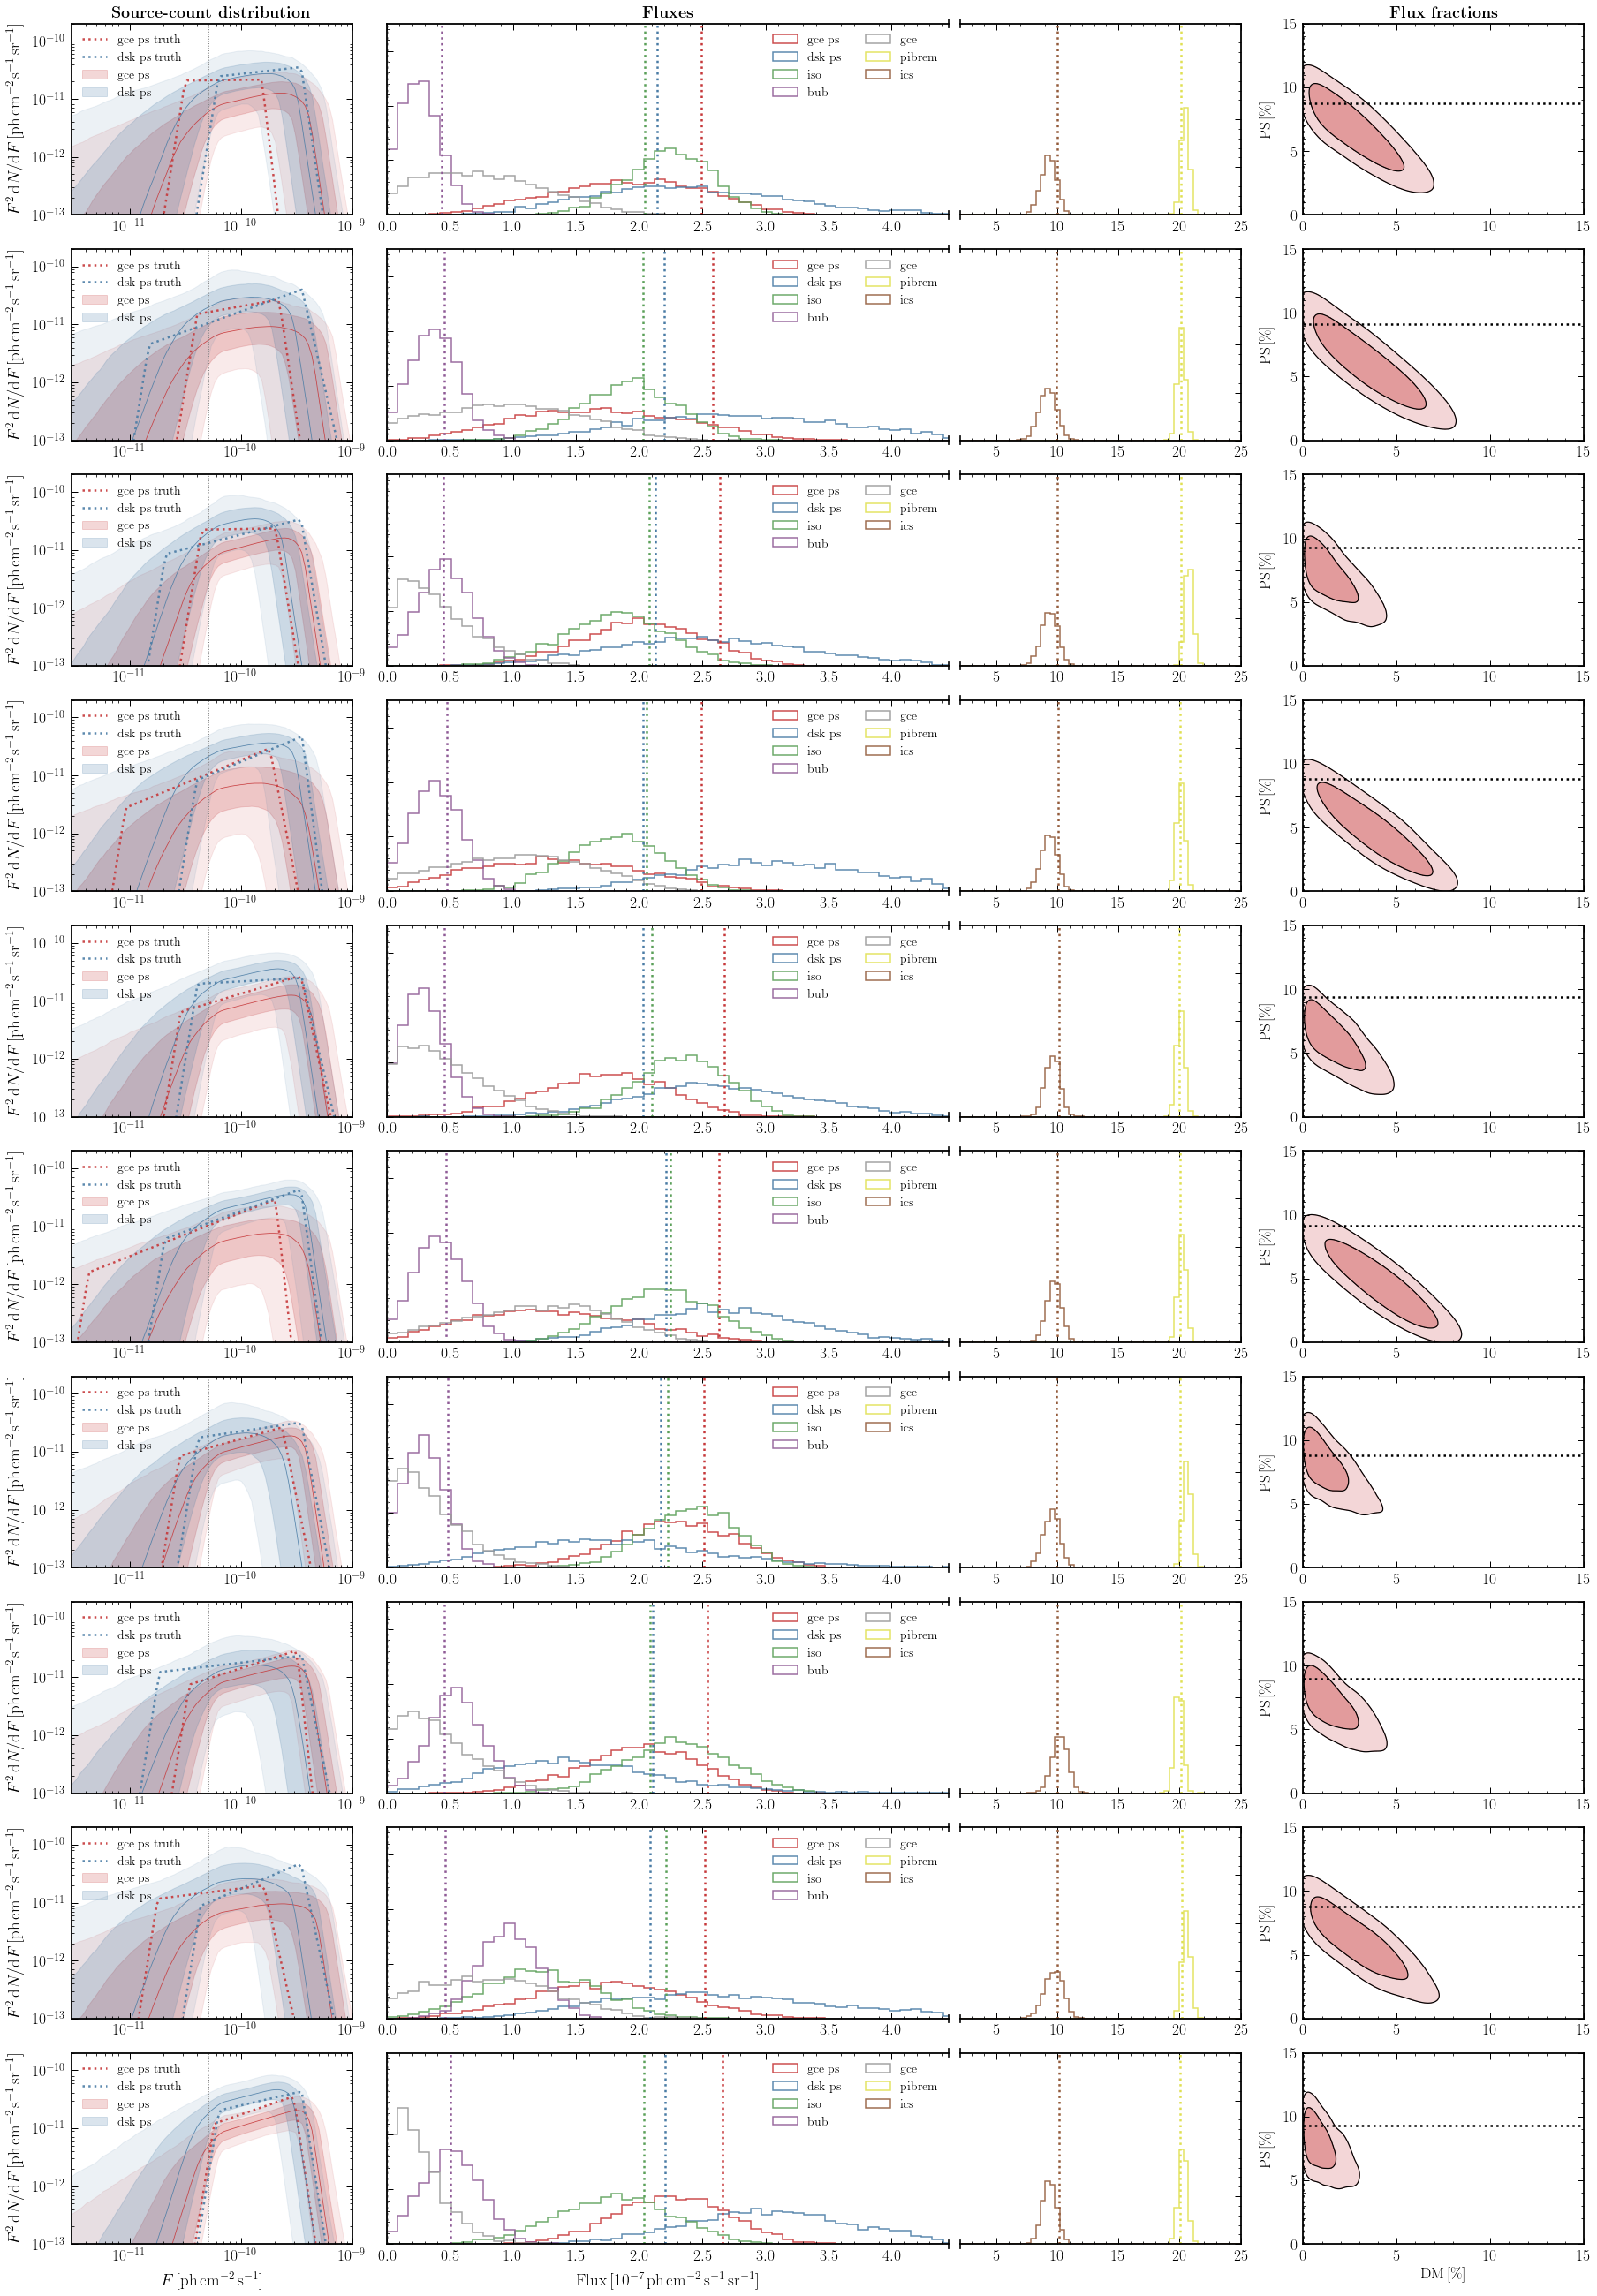

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [48]:
x_presimulated = torch.Tensor(data_map)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = torch.Tensor(thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)
posterior = inference_inst.build_posterior(density_estimator)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, figsize=(25, 36), n_samples=5000, save_filename='/Users/smsharma/Desktop/' + run_id + '.pdf') 

### Analysis on data

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


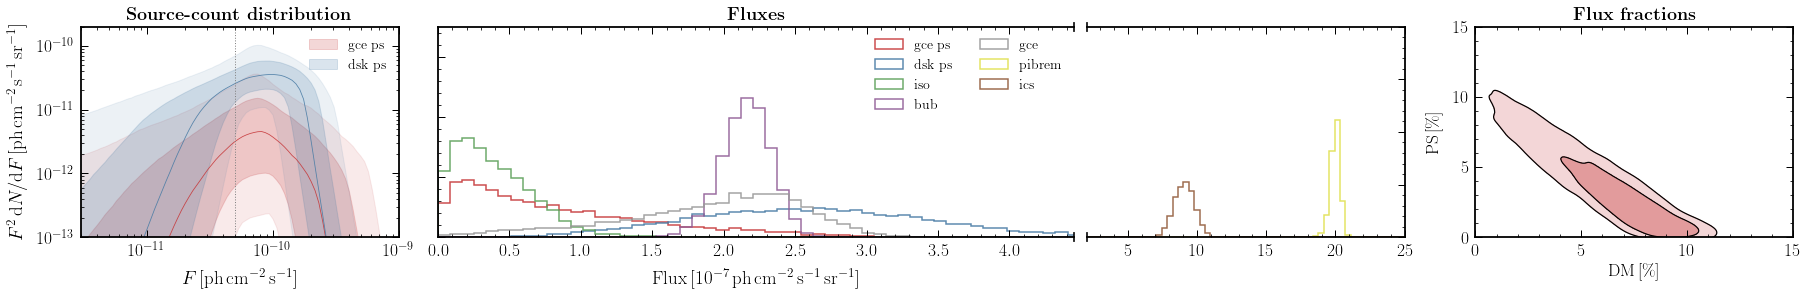

<Figure size 432x324 with 0 Axes>

In [70]:
coeff_ary = [0.]

x_test = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy() for coeff in coeff_ary]))
inference_inst.x_shape = x_shape_from_simulation(x_test)

posterior = inference_inst.build_posterior(density_estimator)

make_plot(posterior=posterior, x_test=x_test, theta_test=None, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm, is_data=True, signal_injection=True, figsize=(25, 4), save_filename="../paper/plots/data_fid_sbi.pdf", n_samples=10000)

### Signal injection on data

In [ ]:
posterior = inference_inst.build_posterior(density_estimator)

coeff_ary = np.linspace(0, 0.9, 5)
x_test = torch.Tensor(np.array([get_signal_injection(coeff).detach().numpy() for coeff in coeff_ary]))
make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_normalize=roi_normalize, roi_counts_normalize=masks_list[0], is_data=True, signal_injection=True, save_filename="../paper/plots/data_fid_sbi.pdf", n_samples=50000)

### NPTF analysis on data

Removed no burn in


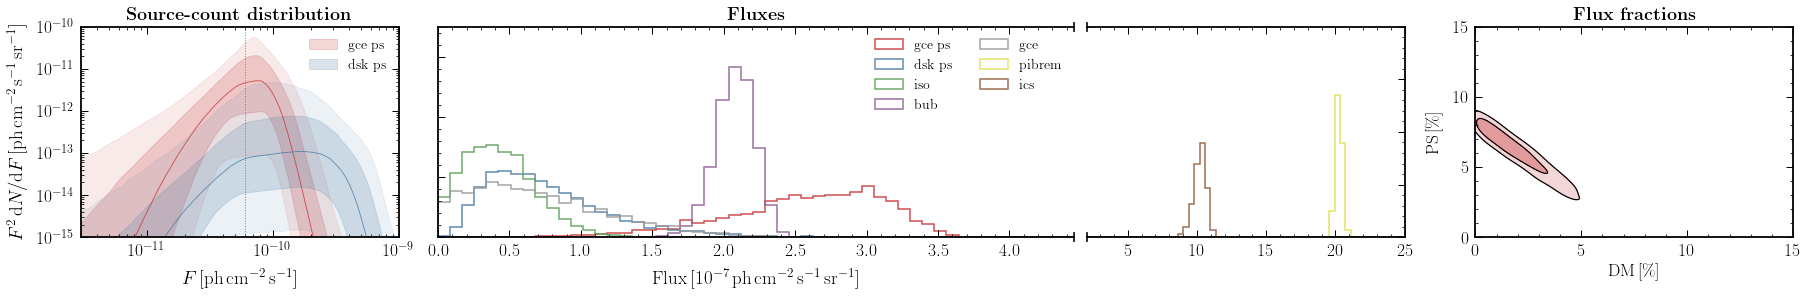

<Figure size 432x324 with 0 Axes>

In [273]:
samples_weighted = torch.Tensor(np.load("../data/nptfit_samples/runs_25_ModelO_1_0.8_samples_new.npz")["samples_thinned_flattened"])
samples_weighted = torch.unsqueeze(samples_weighted, 0)

fermi_data = torch.Tensor(np.load("../data/fermi_data/fermidata_counts.npy"))
fermi_data = torch.unsqueeze(fermi_data, 0)

roi_counts_normalize = cm.make_mask_total(nside=128, band_mask = True, band_mask_range = 2, mask_ring = True, inner = 0, outer = 25)

fermi_data = fermi_data.detach().numpy()
make_plot(posterior=samples_weighted, x_test=fermi_data, x_data_test=fermi_data, theta_test=theta_test, roi_normalize=roi_normalize, roi_counts_normalize=roi_counts_normalize, is_data=True, signal_injection=False, figsize=(25, 4), nptf=True, save_filename="../paper/plots/data_fid_nptf.pdf")

### Mismodeling

In [86]:
# iso, bub, psc, dif
prior_poiss = [[0.9, 0.18, 0.5, 9. / 8., 0.8], [1., 0.22, 0.55, 9.1 / 8., 0.83]]

# gce, dsk
prior_ps = [[1.0, 10.0, 1.1, -10.0, 20.0, 2., 0.001, 10.0, 1.1, -10.0, 24.0, 0.1], [1.1, 20.0, 1.99, -9.99, 25.0, 4.99, 1.0, 20.0, 1.99, -9.99, 25.0, 4.99]]

prior = utils.BoxUniform(low=torch.tensor([0.0] + prior_poiss[0] + prior_ps[0]), high=torch.tensor([0.01] + prior_poiss[1] + prior_ps[1]))

thetas = prior.sample((5,))

temps_poiss_sim = [temp_gce, temp_iso, temp_bub, temp_psc, temp_mA_pibrem, temp_mA_ics]
temps_ps_sim = [temp_gce, temp_dsk]

maps = [simulator(theta.detach().numpy(), temps_poiss_sim, temps_ps_sim, masks_list[0], roi_mask_norm, roi_mask, pc_inst.psf_r_func) for theta in tqdm_notebook(thetas)]

from operator import itemgetter
data_map = torch.Tensor(list(map(itemgetter(0), maps)))
aux = torch.Tensor(list(map(itemgetter(1), maps)))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/5 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


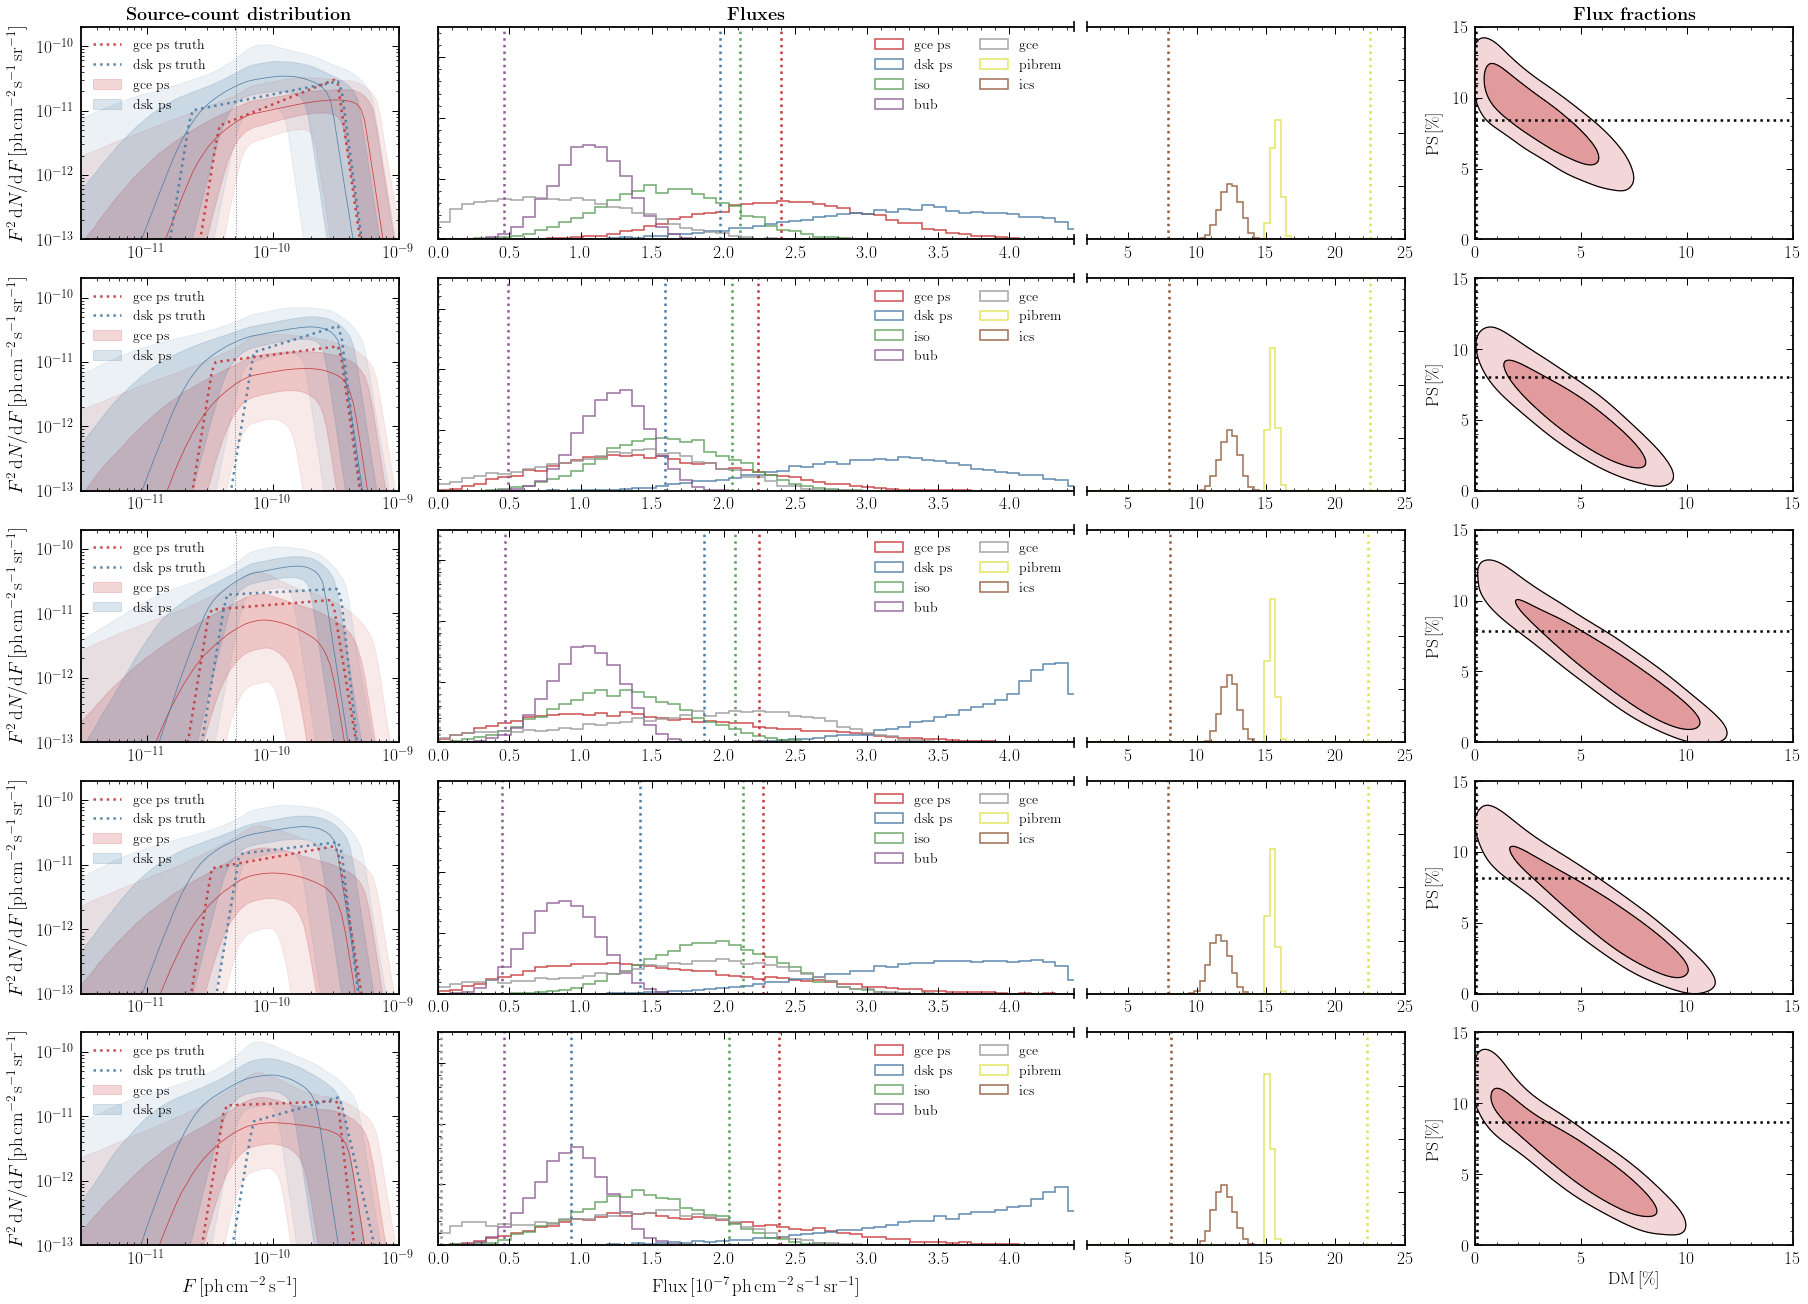

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [87]:
posterior = inference_inst.build_posterior(density_estimator)

x_presimulated = torch.Tensor(data_map)
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = torch.Tensor(thetas)


inference_inst.x_shape = x_shape_from_simulation(x_presimulated)

x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, theta_test=theta_test, roi_normalize=roi_normalize, roi_counts_normalize=roi_mask_norm)

## SNPE-PCA

In [1227]:
# instantiate the neural density estimator
neural_classifier = utils.posterior_nn(model='maf',
                                      embedding_net=nn.Identity(),
                                      hidden_features=50,
                                      num_transforms=4,
)

# setup the inference procedure with the SNPE-C procedure
inference_inst = PosteriorEstimator(prior=prior, density_estimator=neural_classifier, 
                           show_progress_bars=True,
                           logging_level='INFO',
                          device=device.type)

In [1228]:
run_id = '723f6e04b48b4238b63e1fc66c5b7644'
n_components = 24

data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/mlruns/0/' + run_id + '/artifacts/density_estimator')

2021/02/24 13:49:28 WARNING mlflow.pytorch: Stored model version '1.7.0' does not match installed PyTorch version '1.6.0'


In [1229]:
import joblib
from sklearn.decomposition import PCA, IncrementalPCA

pca_model = joblib.load("../data/models/pca_96_train_ModelO_gamma_fix.p")

/Users/smsharma/anaconda3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator IncrementalPCA from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [1230]:
x_data_presimulated = torch.Tensor(data_map)
x_presimulated = torch.Tensor([pca_model.transform(in_map)[:,:n_components] for in_map in x_data_presimulated])
x_aux_presimulated = torch.Tensor(aux)
theta_presimulated = torch.Tensor(thetas)

inference_inst.x_shape = x_shape_from_simulation(x_presimulated)

In [1231]:
posterior = inference_inst.build_posterior(density_estimator)

(1.0, 96.0)

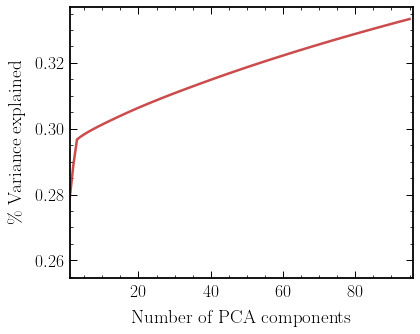

In [1232]:
plt.plot(np.arange(96), np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel("Number of PCA components")
plt.ylabel("\% Variance explained")
plt.xlim(1, 96)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


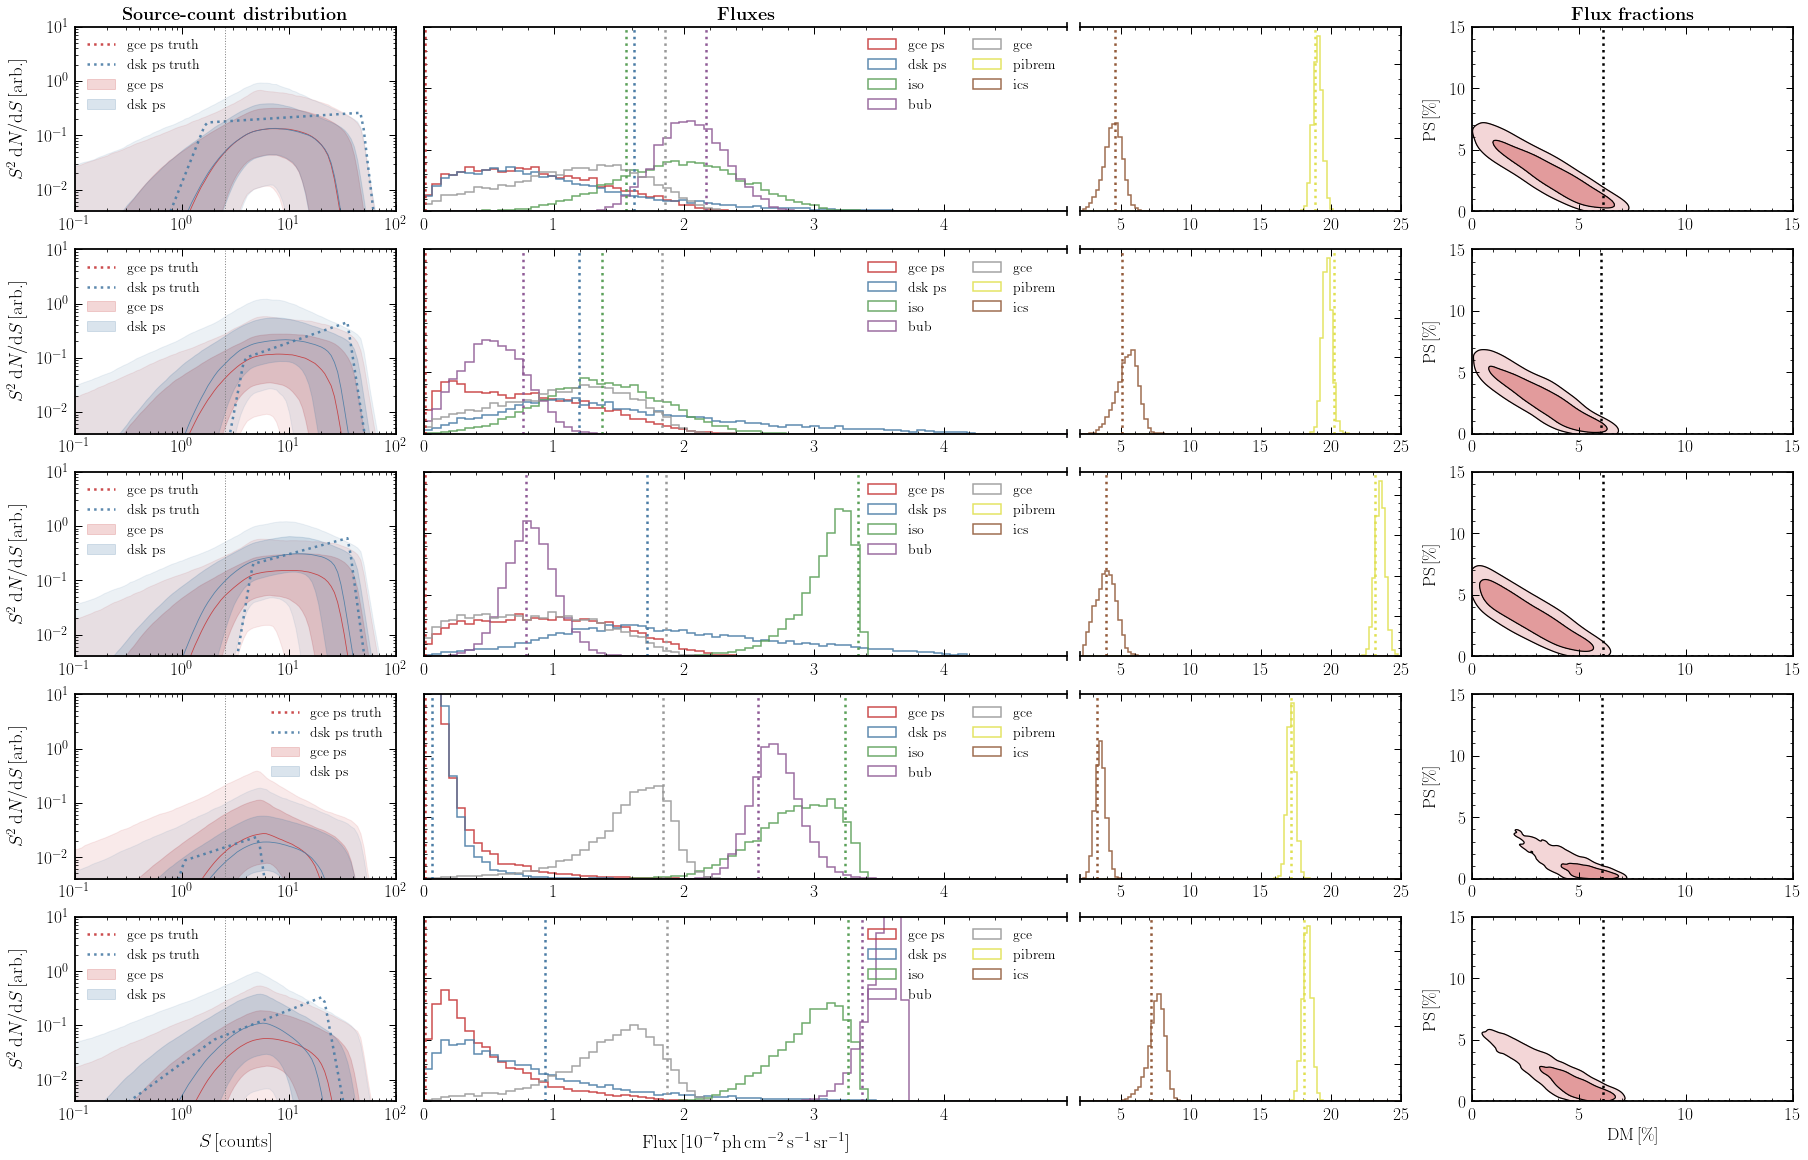

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

<Figure size 432x324 with 0 Axes>

In [1233]:
x_test = torch.cat([x_presimulated, x_aux_presimulated], axis=-1)
theta_test = theta_presimulated

make_plot(posterior=posterior, x_test=x_test, x_data_test=x_data_presimulated, theta_test=theta_test)

In [1234]:
def get_signal_injection_pca(coeff, plot_map=False, n_components=96):
    in_map = np.load("../data/fermi_data/fermidata_counts.npy") + coeff * np.random.poisson(temp_gce)
    in_map[hp_mask] = 0
    
    if plot_map:
        hp.mollview(in_map, max=100)

    in_map = torch.Tensor(in_map[~masks_list[0]])
    in_map = in_map.reshape((1, -1, 1))

    log_mean = torch.log(torch.mean(in_map))
    log_std = torch.log(torch.var(in_map).sqrt())

    in_map = torch.Tensor(pca_model.transform(in_map[:,:,0]))[:,:n_components]
    
    log_mean = log_mean.reshape((1, -1))
    log_std = log_std.reshape((1, -1))
    
    data_map = torch.cat([in_map, log_mean, log_std], axis=1)
    
    return data_map

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Removed no burn in


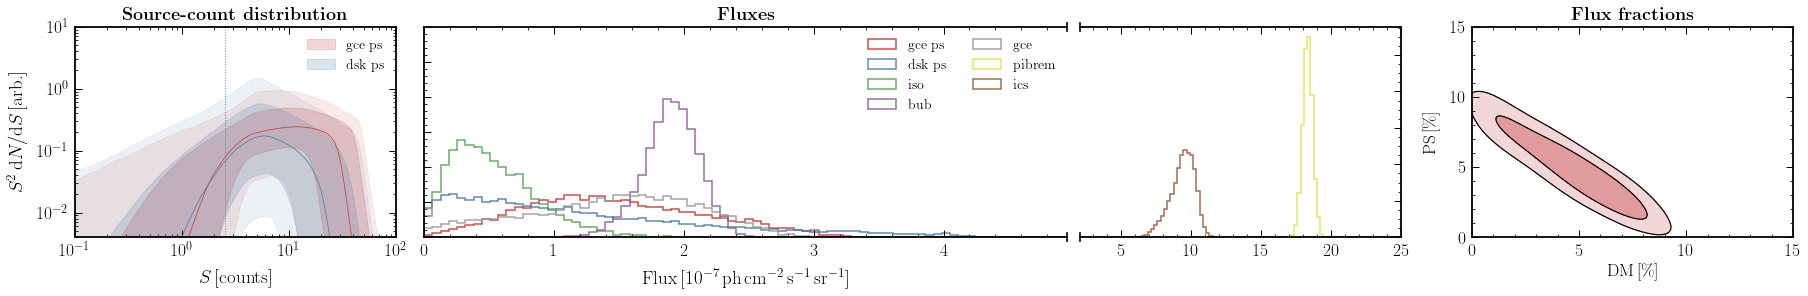

<Figure size 432x324 with 0 Axes>

In [1235]:
coeff_ary = [0.]
x_test = torch.Tensor(np.array([get_signal_injection_pca(coeff, n_components=n_components).detach().numpy() for coeff in coeff_ary]))
make_plot(posterior=posterior, x_test=x_test, x_data_test=x_data_presimulated, theta_test=theta_test, is_data=True, signal_injection=True, figsize=(25, 4))

## SNRE

In [55]:
sys.path.append("../")
sys.path.append(".")
sys.path.append("../sbi/")

from sbi.inference import RatioEstimator

sg_embed = SphericalGraphCNN(nside_list, indexes_list, n_aux=2, n_params=2).to(device)

# Instantiate the neural density estimator
neural_classifier = utils.classifier_nn(model="mlp_mixed", embedding_net_x=sg_embed)

# Setup the inference procedure with NPE
posterior_estimator = RatioEstimator(prior=prior, classifier=neural_classifier, show_progress_bars=True, logging_level="INFO")

In [56]:
run_id = 'd959387df3984adc840a72c8b4047c9d'

data_dir = '/scratch/sm8383/sbi-fermi/data/'
model_uri = "runs:/{}/density_estimator".format(run_id)
density_estimator = mlflow.pytorch.load_model('/Users/smsharma/mlruns/0/' + run_id + '/artifacts/density_estimator')

2021/02/18 11:41:13 WARNING mlflow.pytorch: Stored model version '1.7.0' does not match installed PyTorch version '1.6.0'


In [57]:
posterior = posterior_estimator.build_posterior(density_estimator)
posterior_estimator.x_shape = x_shape_from_simulation(x_presimulated)

In [88]:
truth_idx = 0
x_o = torch.cat([x_presimulated[truth_idx], x_aux_presimulated[truth_idx]], axis=-1)
posterior_samples = posterior.sample([50], x=x_o, sample_with_mcmc=True, mcmc_method="nuts")

Sample: 100%|██████████| 521/521 [09:25,  1.09s/it, step size=5.26e-01, acc. prob=0.644]


In [108]:
np.transpose([np.mean(posterior_samples.detach().numpy(), axis=0), theta_presimulated[0].detach().numpy()])

array([[ 1.2654042 ,  0.9381074 ],
       [ 0.6119688 ,  1.0152464 ],
       [ 1.0364982 ,  0.8255643 ],
       [ 0.95088965,  0.7791615 ],
       [ 7.6009755 ,  8.794834  ],
       [ 2.5160046 ,  1.6621089 ],
       [ 0.34260735,  0.8963742 ],
       [14.802166  , 13.866877  ],
       [ 1.4710561 ,  1.4423819 ],
       [-4.483611  , -8.074902  ],
       [24.654509  ,  5.536254  ],
       [ 4.3863845 ,  4.7412066 ],
       [ 0.9101762 ,  1.8060533 ],
       [18.175697  , 15.529869  ],
       [ 1.5949386 ,  1.3168153 ],
       [-6.2692018 , -4.2470574 ],
       [48.65707   , 21.255575  ],
       [ 4.431909  ,  0.42830312]], dtype=float32)